In [42]:
'''
Format:
'id'
'annotation_id'
'per_annotation_id'
'persona'
'input.keywords'
'input.images'
'input.sentences'
'output.sentences'
'''

import os
import glob
import json
import pprint
from collections import defaultdict,Counter
#from config import model_config as config



# show per-persona sentences
def aggregate_data(data, STYLE_ORDER = ['gender', 'country', 'age', 'ethnic', 'education', 'politics', 'tod'], verbose=True):
    # persona dictionaries
    STYLE_ORDER = ['age']
    combined_dict = defaultdict(lambda: defaultdict(list))
    controlled_dict = defaultdict(list)

    for pid,obj in enumerate(data):
        sents = obj['output.sentences']
        sents = [sents]
        styles = obj['persona']

        # (1) combined setting dictionary
        for s,v in styles.items():
            if v.strip() == '':
                v = 'Empty'
            combined_dict[s][v] += sents

        # (2) controlled setting dictionary
        style_ordered_tuple = tuple([styles[s] for s in STYLE_ORDER])
        assert len(style_ordered_tuple) == len(STYLE_ORDER)
        controlled_dict[style_ordered_tuple] += sents

    if verbose:
        # combined setting
        #print(combined_dict)
        print ('Combined dictionary',combined_dict.keys())
        print ('Combined Combinations',' '.join(
            ['%s:%d'%(k,len(v)) for k,v in combined_dict.items()]))
        for style, value_dic in combined_dict.items():
            print ('\t target STYLE: %s' % (style))
            print ('\t\t unique value types: %d'%(len(value_dic)))
            print ('\t\t value Dist: ',' '.join(['%s:%d'%(k,len(v)) for k,v in value_dic.items()]))
        print()

        # controlled setting
        print ('Controlled dictionary: total combination of styles=',len(controlled_dict))
        for style_order, value_dic in list(controlled_dict.items()):
            print('\t combination:',style_order, len(value_dic))
        print('\t ...')
    return combined_dict, controlled_dict


def read_dataset(data_dir, level):
    data = []
    for dt in ['train','valid','test']:
        d = []
        files = glob.glob(os.path.join(data_dir, level, dt)+'/*.json')
        for file in files:
            with open(file) as fin:
                obj = dict(json.load(fin))
                obj['filename'] = os.path.basename(file)
                d.append(obj)
        print('Number of files/loaded-data: {}/{} in {}'.format(len(files),len(d), dt))
        data.append(d)

    train,valid,test = tuple(data)
    return train, valid, test

def write_dataset(data_dir, level, data):
    assert len(data) == 3
    for data_per_type, datatype in zip(data, ['train','valid','test']):
        dir = os.path.join(data_dir, level, datatype)
        if not os.path.exists(dir):
            os.makedirs(dir)

        for obj in data_per_type:
            with open(os.path.join(dir , obj['filename']), 'w') as f:
                json.dump(obj, f)

        print('Number of files written: {} in {}'.format(len(data_per_type), dir))
    return

In [43]:
train, valid, test = read_dataset('../Data/v2/', 'sentences')

Number of files/loaded-data: 31805/31805 in train
Number of files/loaded-data: 3990/3990 in valid
Number of files/loaded-data: 3982/3982 in test


In [4]:
print(test[0])

{'annotation_id': '30005', 'per_annotation_id': '30005', 'id': '30005_2_2', 'persona': {'country': 'U.K', 'politics': 'Centrist', 'tod': 'Afternoon', 'age': '35-44', 'education': 'Edu-AssociateDegree', 'ethnic': 'Caucasian', 'gender': 'Male'}, 'input.keywords': '(support|friends|family)', 'input.images': 'https://farm5.staticflickr.com/4107/5089174911_6d05ef7058_o.jpg', 'input.sentences': 'friends and family were there for support', 'output.sentences': 'Everyone in the bridal party had a wonderful time at the wedding.', 'filename': '30005_2_2.json'}


In [46]:


combined_dict, controlled_dict = aggregate_data(test+train+valid, verbose=False)
train_x = []
train_y = []
a=b=c=d=e=f=0
for style_order, value_dic in list(controlled_dict.items()):
    for i in range(len(value_dic)):
        train_x.append(value_dic[i])
        #print(style_order)
        if style_order[0] == '25-34':
            a+=1 
            train_y.append(0)    
        elif style_order[0] == '55-74' or style_order[0] == '45-54':
            b+=1
            train_y.append(1)
        '''elif style_order[0] == 'Male' and style_order[1] == 'NoDegree':
            c+=1
        elif style_order[0] == 'Female' and style_order[1] == 'NoDegree':
            d+=1
        elif style_order[0] == 'Male' and style_order[1] == 'Master':
            e+=1
        elif style_order[0] == 'Female' and style_order[1] == 'Master':
            f+=1'''
print(a)
print(b)
print(c)
print(d)
print(e)
print(f)

15877
8203
0
0
0
0


In [99]:
count = 0
import re
import unicodedata
def unicodeToAscii(s):
    return ''.join(
    c for c in unicodedata.normalize('NFD', s)
    if unicodedata.category(c) != 'Mn'
    )
def normalizeString(s):
    s = unicodeToAscii(s.lower())
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s
for style_order, value_dic in list(controlled_dict.items()):
    #print(value_dic)
    for i in value_dic:
        i = normalizeString(i)
        if count < len(i.split(' ')):
            count = len(i.split(' '))
            print(i)
            #print(i.split(' '))
        #print(i)
print(count)

everyone in the bridal party had a wonderful time at the wedding.
family came from all over the country to love and celebrate the happy couple.
the parents of the bride and groom were ecstatic that everything went off without a hitch!
the family went outside and they saw that all of the trails were closed due to the snow.
batman showed his face as well, scowling at the other superheros... i wonder if there will be a spiderman vs batman reenactment.
as they headed back to the house, they want to be sure they had a picture of where they were staying and how it looked covered with a blanket of snow.
i realize i would normally close the door, but the damp and snow gave me pause, so i placed a shovel in the doorway, to ensure i was able to get back in.
i knew enough to try to agree with my wife's father's politics, but introductions were a stumper, so i finally just said, "hello everyone, some of you know me as your son, some of you don't, but i think we can all just have  a good time toget

In [58]:
l = ['18-24', '25-34', '35-44']
for style_order, value_dic in list(controlled_dict.items()):
    #if (style_order[0] == 'Male'):
        #print(value_dic[0])
    print('\t combination:',style_order, len(value_dic))

	 combination: ('Male',) 1368
	 combination: ('Female',) 2588
	 combination: ('Non-binary',) 26


In [70]:
train_x = []
train_y = []
for style_order, value_dic in list(controlled_dict.items()):
    for i in range(len(value_dic)):
        train_x.append(value_dic[i])
        if style_order[0] == 'Male':
            train_y.append(0)    
        elif style_order[0] == 'Female':
            train_y.append(1)

In [108]:
print(len(train_x))
print(train_y[0])

3982
0


In [52]:
len(a[0])

170

In [29]:
STYLE_ORDER = ['gender']
combined_dict_train, controlled_dict_train = aggregate_data(train, STYLE_ORDER, verbose=True)
combined_dict_valid, controlled_dict_valid = aggregate_data(valid, STYLE_ORDER, verbose=True)
combined_dict_test, controlled_dict_test = aggregate_data(test, STYLE_ORDER, verbose=True)
for style_order, value_dic in list(controlled_dict_train.items()):
    for i in range(len(value_dic)):
        train_x.append(Lang.normalizeString(value_dic[i]))
        if style_order[0] == 'Male':
            train_y.append(0)
        elif style_order[0] == 'Female':
            train_y.append(1)
for style_order, value_dic in list(controlled_dict_valid.items()):
    for i in range(len(value_dic)):
        valid_x.append(Lang.normalizeString(value_dic[i]))
        if style_order[0] == 'Male':
            valid_y.append(0)
        elif style_order[0] == 'Female':
            valid_y.append(1)
for style_order, value_dic in list(controlled_dict_test.items()):
    for i in range(len(value_dic)):
        test_x.append(Lang.normalizeString(value_dic[i]))
        if style_order[0] == 'Male':
            test_y.append(0)
        elif style_order[0] == 'Female':
            test_y.append(1)

Combined dictionary dict_keys([])
Combined Combinations 

Controlled dictionary: total combination of styles= 0
	 ...
Combined dictionary dict_keys([])
Combined Combinations 

Controlled dictionary: total combination of styles= 0
	 ...
Combined dictionary dict_keys([])
Combined Combinations 

Controlled dictionary: total combination of styles= 0
	 ...


In [100]:
import spacy
nlp = spacy.load("en_core_web_lg")
from spacy.tokenizer import Tokenizer
nlp.tokenizer = Tokenizer(nlp.vocab)

In [105]:
text = 'nsubj'
doc = nlp(text)
for i in doc:
    print(i.vector)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [107]:
import numpy as np
nb_classes = 6
targets = np.array([[2, 3, 4, 0]]).reshape(-1)
one_hot_targets = np.eye(nb_classes)[targets]
print(one_hot_targets)

[[0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0.]]


In [3]:
import matplotlib.pyplot as plt
import numpy as np


In [58]:
#values=np.cumsum(np.random.randn(1000,1))
#acc_switch = [57.89,52.39,47.3,41.2,32.9,32.4,32.47,33.26,33.94,33.33,35.34,34.3,34.91,33.38,35.14,35.26,36.71,35.24,39.25,42.38,34.32,34.53,33.94,35.52,34.04,35.44,35.43,35.37,37.42,37.68,38.97,34.43,35.67,35.7,34.15,35.19,35.9,37.93,37.37,34.93]
acc_switch = [0.6117294520547946, 0.4332191780821918, 0.4041095890410959, 0.3912671232876712, 0.4580479452054795, 0.4375, 0.4503424657534247, 0.4345034246575342, 0.442208904109589, 0.444777397260274, 0.4443493150684932, 0.4242294520547945, 0.4370719178082192, 0.4653253424657534, 0.4383561643835616, 0.4580479452054795, 0.4464897260273973, 0.4606164383561644, 0.444777397260274, 0.4529109589041096, 0.4370719178082192, 0.4387842465753425, 0.461472602739726, 0.4700342465753425, 0.4486301369863014, 0.449486301369863, 0.4370719178082192, 0.4511986301369863, 0.4366438356164384, 0.4383561643835616, 0.4571917808219178, 0.4490582191780822, 0.4434931506849315, 0.4554794520547945, 0.4413527397260274, 0.4554794520547945, 0.4464897260273973, 0.4464897260273973, 0.4477739726027397, 0.4336472602739726, 0.4413527397260274, 0.4392123287671233, 0.4623287671232877, 0.4589041095890411, 0.4297945205479452, 0.4524828767123288, 0.4580479452054795, 0.4357876712328767, 0.4242294520547945, 0.4452054794520548, 0.4285102739726027, 0.4417808219178082, 0.4297945205479452, 0.4533390410958904, 0.442208904109589, 0.4571917808219178, 0.4507705479452055, 0.4362157534246575, 0.4387842465753425, 0.4443493150684932, 0.4537671232876712, 0.442208904109589, 0.4507705479452055, 0.4460616438356164, 0.4456335616438356, 0.4280821917808219, 0.4456335616438356, 0.4477739726027397, 0.4469178082191781, 0.4452054794520548]
for i in range(len(acc_switch)):
    acc_switch[i] = acc_switch[i]*100 + 10
acc_switch = acc_switch[:41]
acc_switch_1 = [0.4160958904109589, 0.3784246575342466, 0.3762842465753425, 0.4101027397260274, 0.4169520547945205, 0.4006849315068493, 0.4345034246575342, 0.4306506849315068, 0.4417808219178082, 0.444777397260274, 0.4546232876712329, 0.4332191780821918, 0.4464897260273973, 0.4379280821917808, 0.46875, 0.4554794520547945, 0.4546232876712329, 0.4332191780821918, 0.4370719178082192, 0.4357876712328767, 0.4375, 0.4636130136986301, 0.4456335616438356, 0.4477739726027397, 0.4383561643835616, 0.4644691780821918, 0.4439212328767123, 0.4721746575342466, 0.4396404109589041, 0.4550513698630137, 0.4383561643835616, 0.4430650684931507, 0.4306506849315068, 0.4259417808219178, 0.4546232876712329, 0.4276541095890411, 0.442208904109589, 0.4499143835616438, 0.4666095890410959, 0.4345034246575342, 0.4101027397260274, 0.4511986301369863, 0.4550513698630137, 0.4357876712328767]
for i in range(len(acc_switch_1)):
    acc_switch_1[i] = acc_switch_1[i]*100 + 8
acc_switch_1 = acc_switch_1[:41]
# use the plot function
#acc_org = [48.12,52.33,56.32,68.22,72,72.87,73.50,74.09,73.81,73.68,73.02,72.18,73.91,74.41,73.42,73.63,72.79,73.15,71.75,68.6,75.28,75.86,75.53,75.79,75.38,74.64,75.03,75.38,74.77,74.42,73.7,76.19,75.89,75.51,75.56,75.64,76.24,75.61,74.70,77.67]
acc_org = [0.5017123287671232, 0.6652397260273972, 0.7196061643835616, 0.7247431506849316, 0.7097602739726028, 0.7367294520547946, 0.709332191780822, 0.742722602739726, 0.7457191780821918, 0.7602739726027398, 0.7624143835616438, 0.7632705479452054, 0.7675513698630136, 0.7795376712328768, 0.7799657534246576, 0.7863869863013698, 0.7679794520547946, 0.7752568493150684, 0.7679794520547946, 0.7744006849315068, 0.7731164383561644, 0.7641267123287672, 0.7624143835616438, 0.7564212328767124, 0.773972602739726, 0.7752568493150684, 0.771404109589041, 0.7636986301369864, 0.7791095890410958, 0.778681506849315, 0.7636986301369864, 0.7696917808219178, 0.7611301369863014, 0.7564212328767124, 0.7636986301369864, 0.7662671232876712, 0.771832191780822, 0.7684075342465754, 0.7731164383561644, 0.7675513698630136, 0.7735445205479452, 0.759417808219178, 0.7662671232876712, 0.7632705479452054, 0.776541095890411, 0.7611301369863014, 0.7611301369863014, 0.7671232876712328, 0.7709760273972602, 0.7709760273972602, 0.7696917808219178, 0.7542808219178082, 0.7628424657534246, 0.7662671232876712, 0.7679794520547946, 0.7636986301369864, 0.7688356164383562, 0.7551369863013698, 0.764554794520548, 0.7726883561643836, 0.7688356164383562, 0.7564212328767124, 0.7585616438356164, 0.7688356164383562, 0.7577054794520548, 0.7410102739726028, 0.7671232876712328, 0.7564212328767124, 0.7611301369863014, 0.759417808219178]
for i in range(len(acc_org)):
    acc_org[i] = acc_org[i]*100
#bleu = [5.47,9.08,10.28,10.86,11.2,12.1,12.54,13.22,13.46,13.75,14.12,13.79,14.53,14.94,15.29,15.51,15.65,15.3,15.46,16.31,16.39,16.53,16.74,16.74,16.7,16.96,17.19,17.44,17.4,17.41,17.84,17.68,17.98,17.99,18.12,18.34,18.31]
bleu = [0.06585471597640574, 0.11290827599392703, 0.11328301921195566, 0.1287522775452242, 0.13023970594564158, 0.1363529252022145, 0.14193523663613508, 0.14290001821713938, 0.14537967443202143, 0.15195752524085315, 0.15097300337679062, 0.15613830485967523, 0.15964296878066894, 0.16431111296080916, 0.16451694263698724, 0.1588573727800438, 0.16626238517368028, 0.1693929610290805, 0.16998519126564143, 0.1716373855458197, 0.16786248124854378, 0.17592988917598618, 0.17461082625620575, 0.17863758634695728, 0.17176648552881627, 0.1761070972585789, 0.1798588130095892, 0.180745577407143, 0.17181287570861964, 0.18303777260379744, 0.18367979281426508, 0.17993576177599632, 0.18422249072909325, 0.18294359172246652, 0.1821760731263291, 0.1724273182232777, 0.1837980228505491, 0.18315660000772188, 0.1758276159365851, 0.18715266948171283, 0.17410049449283072, 0.18411118724596445, 0.18525762797621875, 0.185337836095571, 0.18467569297783828, 0.1871533514459608, 0.18787252474642266, 0.1860165531471574, 0.18481751266950977, 0.18539381294407012, 0.18634759678752985, 0.18584774163837936, 0.18759282813819406, 0.18574963429724256, 0.18583014314738397, 0.18732652059516883, 0.18716236879509696, 0.1824495414063948, 0.17594484936281285, 0.18860933606035224, 0.1876040520015069, 0.1874732005434094, 0.1900488545681461, 0.18832748160653787, 0.19043975522537307, 0.1877945517980454, 0.1909616107924533, 0.18927560893848094, 0.18401687053992205, 0.18892830897980886]
for i in range(len(bleu)):
    bleu[i] = bleu[i]*100
bleu = bleu[:41]

bleu_1 = [0.09273886088177818, 0.12320292644639516, 0.13048685901572257, 0.1383789665061796, 0.14610735644603434, 0.1522348530566643, 0.1588799821697051, 0.16364271103362088, 0.16771505754414517, 0.1705966525747844, 0.17554382564126908, 0.1778185723849584, 0.17980471331062142, 0.18287692306744852, 0.1841722666922926, 0.18733970570991118, 0.18752113006252072, 0.1917572086615753, 0.18943526701333502, 0.19448326983788752, 0.19233828535771935, 0.19439755793341817, 0.19406370066062958, 0.19525363302624937, 0.19652834285002208, 0.19569796604045425, 0.20024629011948877, 0.19200737887909872, 0.20159396032407045, 0.2031494065003507, 0.20377446210144104, 0.2029220613597229, 0.20113525928731493, 0.2002030559541496, 0.19857785668906988, 0.20301467288548142, 0.20126640245043853, 0.19980472581130915, 0.20315860069731478, 0.2070474478624945, 0.20349695074525345, 0.1996988275711312, 0.2023418184262639, 0.20283817419545447]
for i in range(len(bleu_1)):
    bleu_1[i] = bleu_1[i]*100
bleu_1 = bleu_1[:41]





In [62]:
acc_switch = [0.6166666666666667, 0.5084325396825397, 0.5029761904761905, 0.46875, 0.49206349206349204, 0.49851190476190477, 0.5079365079365079, 0.4955357142857143, 0.47668650793650796, 0.49603174603174605, 0.5049603174603174, 0.5009920634920635, 0.5114087301587301, 0.5163690476190477, 0.5079365079365079, 0.5054563492063492, 0.5173611111111112, 0.5252976190476191, 0.5009920634920635, 0.5347222222222222, 0.5386904761904762, 0.5372023809523809, 0.5337301587301587, 0.5431547619047619, 0.5471230158730159, 0.5213293650793651, 0.5406746031746031, 0.5233134920634921, 0.5302579365079365, 0.5386904761904762, 0.5446428571428571, 0.5396825396825397, 0.529265873015873, 0.5297619047619048, 0.5376984126984127, 0.5372023809523809, 0.5471230158730159, 0.5376984126984127, 0.5357142857142857, 0.5372023809523809, 0.5372023809523809, 0.5451388888888888, 0.5406746031746031, 0.535218253968254, 0.5376984126984127, 0.5525793650793651, 0.5406746031746031, 0.5282738095238095, 0.5446428571428571, 0.5406746031746031, 0.5471230158730159, 0.533234126984127, 0.5486111111111112, 0.5481150793650794, 0.53125, 0.5505952380952381, 0.5416666666666666, 0.5421626984126984, 0.5421626984126984, 0.5243055555555556, 0.5461309523809523, 0.5297619047619048, 0.5372023809523809, 0.5476190476190477, 0.5406746031746031, 0.5466269841269841, 0.5476190476190477]

for i in range(len(acc_switch)):
    acc_switch[i] = acc_switch[i]*100 + 10
acc_switch = acc_switch[:41]

bleu = [0.0608987635032274, 0.09900143311725726, 0.11908713329287271, 0.1260336508211774, 0.13045183157831572, 0.1320773053395616, 0.13163800090966216, 0.13931354746872435, 0.14018645774464752, 0.14445070749526415, 0.14779163721721988, 0.14999217201832588, 0.1498962324384997, 0.15597977671725774, 0.15721497267662102, 0.1592056981959049, 0.16274422220347082, 0.1626755230435031, 0.16837001039288257, 0.164470899164976, 0.1698776111551207, 0.16805396870810627, 0.17432857774262106, 0.17309873170958578, 0.17337847416109778, 0.17740798998539584, 0.17563565791027316, 0.17637725120904893, 0.1804396520472987, 0.1769136397250931, 0.1797581360809338, 0.17944411129416443, 0.17872817391754145, 0.18206964202574555, 0.18597353003756192, 0.18176030943216442, 0.18599138646884897, 0.18486071690485928, 0.18615109721451242, 0.18788550480409533, 0.18815362511136416, 0.18717022090735722, 0.18570533180846321, 0.18658907494359467, 0.18747476322032494, 0.18774340303063472, 0.18646812959371104, 0.18950294844774201, 0.18982651337172596, 0.1847767624504981, 0.19331687633654446, 0.18831110874321388, 0.19103004124107414, 0.19017956881452783, 0.1942180324871153, 0.1932076643276103, 0.1936750073077121, 0.1915570526798469, 0.18886602460446547, 0.19226935290667033, 0.19153304661676446, 0.19090892107140336, 0.1932869726185308, 0.1877415546584385, 0.191711090825951, 0.1920801076913596, 0.1925590712894775]
bleu = [0.06585471597640574, 0.11290827599392703, 0.11328301921195566, 0.1287522775452242, 0.13023970594564158, 0.1363529252022145, 0.14193523663613508, 0.14290001821713938, 0.14537967443202143, 0.15195752524085315, 0.15097300337679062, 0.15613830485967523, 0.15964296878066894, 0.16431111296080916, 0.16451694263698724, 0.1588573727800438, 0.16626238517368028, 0.1693929610290805, 0.16998519126564143, 0.1716373855458197, 0.16786248124854378, 0.17592988917598618, 0.17461082625620575, 0.17863758634695728, 0.17176648552881627, 0.1761070972585789, 0.1798588130095892, 0.180745577407143, 0.17181287570861964, 0.18303777260379744, 0.18367979281426508, 0.17993576177599632, 0.18422249072909325, 0.18294359172246652, 0.1821760731263291, 0.1724273182232777, 0.1837980228505491, 0.18315660000772188, 0.1758276159365851, 0.18715266948171283, 0.17410049449283072, 0.18411118724596445, 0.18525762797621875, 0.185337836095571, 0.18467569297783828, 0.1871533514459608, 0.18787252474642266, 0.1860165531471574, 0.18481751266950977, 0.18539381294407012, 0.18634759678752985, 0.18584774163837936, 0.18759282813819406, 0.18574963429724256, 0.18583014314738397, 0.18732652059516883, 0.18716236879509696, 0.1824495414063948, 0.17594484936281285, 0.18860933606035224, 0.1876040520015069, 0.1874732005434094, 0.1900488545681461, 0.18832748160653787, 0.19043975522537307, 0.1877945517980454, 0.1909616107924533, 0.18927560893848094, 0.18401687053992205, 0.18892830897980886]
for i in range(len(bleu)):
    bleu[i] = bleu[i]*100
bleu = bleu[:41]







In [49]:
#values=np.cumsum(np.random.randn(1000,1))
acc_switch = [57.89,52.39,47.3,41.2,32.9,32.4,32.47,33.26,33.94,33.33,35.34,34.3,34.91,33.38,35.14,35.26,36.71,35.24,39.25,42.38,34.32,34.53,33.94,35.52,34.04,35.44,35.43,35.37,37.42,37.68,38.97,34.43,35.67,35.7,34.15,35.19,35.9,37.93,37.37,34.93]
for i in range(len(acc_switch)):
    acc_switch[i] = acc_switch[i] + 10
# use the plot function
#acc_org = [48.12,52.33,56.32,68.22,72,72.87,73.50,74.09,73.81,73.68,73.02,72.18,73.91,74.41,73.42,73.63,72.79,73.15,71.75,68.6,75.28,75.86,75.53,75.79,75.38,74.64,75.03,75.38,74.77,74.42,73.7,76.19,75.89,75.51,75.56,75.64,76.24,75.61,74.70,77.67]
bleu = [5.47,9.08,10.28,10.86,11.2,12.1,12.54,13.22,13.46,13.75,14.12,13.79,14.53,14.94,15.29,15.51,15.65,15.3,15.46,16.31,16.39,16.53,16.74,16.74,16.7,16.96,17.19,17.44,17.4,17.41,17.84,17.68,17.98,17.99,18.12,18.34,18.31]
for i in range(len(acc_switch)):
    acc_switch[i] = acc_switch[i] + 10

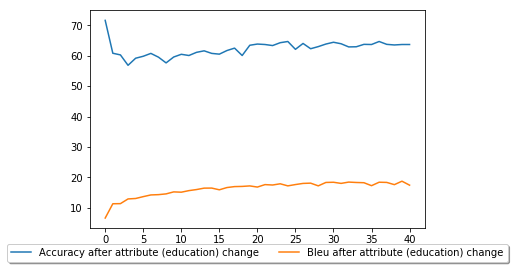

In [64]:
plt.plot(acc_switch, label='Accuracy after attribute (education) change')
#plt.plot(acc_switch_1, label='Accuracy after attribute (age) change when classifier not used')
#plt.plot(acc_org, label='Accuracy for reconstruction (attribute kept same)')
plt.plot(bleu, label='Bleu after attribute (education) change')
#plt.plot(bleu_1, label='Bleu after attribute (age) change when classifier not used')
#plt.legend()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),shadow=True, ncol=2)
#plt.legend(['Accuracy after attribute change'])


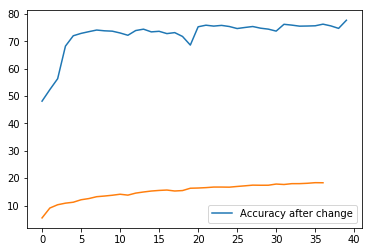

In [14]:
plt.plot(acc_org)
plt.plot(bleu)
plt.legend(['Accuracy after change'])